# Flights Analysis

In Chula Vista, drone flight paths trace a map of the city’s inequality, with poorer residents experiencing far more exposure to the drones’ cameras and rotors than their wealthier counterparts, a WIRED analysis of nearly 10,000 drone flight records from July 2021 to September 2023 found. The drones, while often dispatched for serious incidents like reports of armed individuals, are routinely deployed for minor issues such as shoplifting and loud music

Not every 911 call is met by a drone. Instead, a teleoperator monitoring incoming service calls decides when drone deployment is necessary. WIRED's analysis of 911 calls, totaling 139,522 from July 2021 to September 2023, revealed that drones were used in about 7 percent of the city's service requests. Specifically, drones were dispatched to nearly half of the incidents involving reports of armed individuals and about a quarter of violent crime calls. Calls related to mental health evaluations and domestic violence were frequently met with drone dispatches, according to data published by the city

According to WIRED’s analysis, Chula Vista Police have sent its drones to investigate hundreds of 911 calls about loud music, public intoxication, vandalism, shoplifting and other minor offenses

Links:
- https://airtable.com/appWuNqoK22AtVTWc/tbl9mchBT1m6i7eM2/viwXhGbQkLCEyR5vm?blocks=hide


## Import Data

In [3]:
import geopandas as gpd
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm, trange
from loguru import logger
import datetime
import geopy.distance
import fiona

fiona.drvsupport.supported_drivers['kml'] = 'rw'
fiona.drvsupport.supported_drivers['KML'] = 'rw'
import warnings
warnings.simplefilter(action='ignore')

storage = "/Volumes/easystore/Drones/"

cv_flights = pd.concat(
    [
        chunk
        for chunk in tqdm(
            pd.read_csv(
                f"../../data/outputs/outputs_cv-flight-manifest.csv",
                chunksize=100000,
                dtype=str,
            ),
            desc="Loading data",
        )
    ]
)
per_second = pd.concat(
    [
        chunk
        for chunk in tqdm(
            pd.read_csv(
                f"../../data/outputs/outputs_drone-seconds-block-count.csv",
                chunksize=100000,
                dtype=str,
            ),
            desc="Loading data",
        )
    ]
)
cfs = pd.concat(
    [
        chunk
        for chunk in tqdm(
            pd.read_csv(
                f"../../data/outputs/outputs_cfs-data.csv",
                chunksize=100000,
                dtype=str,
            ),
            desc="Loading data",
        )
    ]
)
cv_flights["drone-date"] =  pd.to_datetime(cv_flights['date'] + " " + cv_flights['time_s'])
cfs["cfs-date"] = pd.to_datetime(cfs["Date"])


types = pd.read_csv('../../data/manually-label/labelled-types.csv')

cv_flights = pd.merge(cv_flights,types, on='clean-type',how='left')
cfs = pd.merge(cfs,types, on='clean-type',how='left')

cv_flights['day'] = pd.to_datetime(cv_flights['date']).dt.floor('D')
cfs['day'] = pd.to_datetime(cfs['Date']).dt.floor('D')

Loading data: 0it [00:00, ?it/s]

Loading data: 0it [00:00, ?it/s]

Loading data: 0it [00:00, ?it/s]

## Analysis Data

I only want to analyze calls on days where there was a flight.  This is because of an error in the data where we dropped flights for a few months.  See Meta Analysis

In [9]:
logger.info(f"Flights from: {cv_flights.sort_values('drone-date').head()['drone-date'].values[-1]} until {cv_flights.sort_values('drone-date').tail()['drone-date'].values[-1]}")
logger.info(f"Calls from: {cfs.sort_values('cfs-date').head()['cfs-date'].values[-1]} until {cfs.sort_values('cfs-date').tail()['cfs-date'].values[-1]}")

2024-05-22 09:25:28.336 | INFO     | __main__:<module>:1 - Flights from: 2021-07-01T12:09:00.000000000 until 2023-09-02T23:27:00.000000000
2024-05-22 09:25:28.478 | INFO     | __main__:<module>:2 - Calls from: 2021-07-01T00:40:26.430000000 until 2023-09-01T23:35:39.883000000


In [11]:
standardized_cfs = cfs[cfs['day'].isin(cv_flights['day'])]
logger.info(f"Total Calls: {standardized_cfs.shape[0]}")

2024-05-22 09:25:46.253 | INFO     | __main__:<module>:2 - Total Calls: 139522


## Drone Response Rate

WIRED's analysis of 911 calls, totaling 139,522 from July 2021 to September 2023, revealed that drones were used in about 7 percent of the city's service requests

In [12]:
response_rate = cv_flights.shape[0]/standardized_cfs.shape[0]
logger.info(f"WIRED's analysis of 911 calls, totaling {standardized_cfs.shape[0]} from July 2021 to September 2023, revealed that drones were used in about {response_rate*100} percent of the city's service requests {standardized_cfs.shape[0]}")

2024-05-22 09:27:39.791 | INFO     | __main__:<module>:2 - WIRED's analysis of 911 calls, totaling 139522 from July 2021 to September 2023, revealed that drones were used in about 6.851249265348834 percent of the city's service requests 139522


### Response Rate by Type of Call

Specifically, drones were dispatched to nearly half of the incidents involving reports of armed individuals and about a quarter of violent crime calls. Calls related to mental health evaluations and domestic violence were frequently met with drone dispatches, according to data published by the city

#### Match on IDs and Date

Match calls for service to drone incident ids based on ID and date.

In [72]:
# Take the last five digits and match on that
cv_flights["match"] = cv_flights["incident_id"].astype(str).apply(lambda x: x.strip().replace(' ','').replace('L','0').replace('l','0')[-5:])

cfs["match"] = (
    cfs["Incident No."].astype(str).apply(lambda x: x.strip().replace(' ','').replace('l','0').replace('L','0')[-5:])
)

matches = cv_flights[cv_flights["match"].isin(cfs["match"])]
matches_joined_cfs = pd.merge(matches, cfs, how="left", on="match",suffixes=['-drones','-cfs'])

# Only keep the ones that happen on the same day
matches_joined_cfs = matches_joined_cfs[
    matches_joined_cfs["drone-date"].dt.date == matches_joined_cfs["cfs-date"].dt.date
]
flights_with_cfs  = matches_joined_cfs.copy()

no_matching_cfs = cv_flights[~cv_flights['id'].isin(flights_with_cfs['id'])].copy()

logger.info(f"Total Flights: {cv_flights.shape[0]}")
logger.info(f"Flights with CFS: {flights_with_cfs.shape[0]}")
logger.info(f"Flights with NaN Incident IDS: {no_matching_cfs[no_matching_cfs['incident_id'].astype(str).str.contains('nan',case=False)].shape[0]}")
logger.info(f"Total unmatched flights: {no_matching_cfs.shape[0]}")

2024-05-22 10:03:40.366 | INFO     | __main__:<module>:19 - Total Flights: 9559
2024-05-22 10:03:40.366 | INFO     | __main__:<module>:20 - Flights with CFS: 7688
2024-05-22 10:03:40.368 | INFO     | __main__:<module>:21 - Flights with NaN Incident IDS: 898
2024-05-22 10:03:40.368 | INFO     | __main__:<module>:22 - Total unmatched flights: 1871


In [73]:
df = []

for t in types['Predicted Category'].drop_duplicates().values:
    number_flights = cv_flights[
    (cv_flights['id'].isin(flights_with_cfs['id'])) &
    (cv_flights['Predicted Category'] == t)
].shape[0]
    number_calls = standardized_cfs[standardized_cfs['Predicted Category']==t].shape[0]
    row = {}
    row['num_drones']=number_flights
    row['num_calls']=number_calls
    row['type'] = t
    df.append(row)
    
df = pd.DataFrame(df)
df['percent_answered'] = df['num_drones']/df['num_calls']
df['percent_not_answered'] = 1 - df['percent_answered']

,num_drones,num_calls,type,percent_answered,percent_not_answered
0,475,24063,Unknown,0.019740,0.980260
1,16,0,Mislabel,inf,-inf
2,797,3363,Violent Crime,0.236991,0.763009
3,250,531,Person with Weapon,0.470810,0.529190
4,1085,11017,Suspicious Circumstances,0.098484,0.901516
5,128,6611,Wanted Person/Vehicle,0.019362,0.980638
6,1619,26057,Disturbance,0.062133,0.937867
7,1266,8842,Welfare Check,0.143180,0.856820
8,676,17240,Property Crime,0.039211,0.960789
9,1057,27992,Traffic,0.037761,0.962239


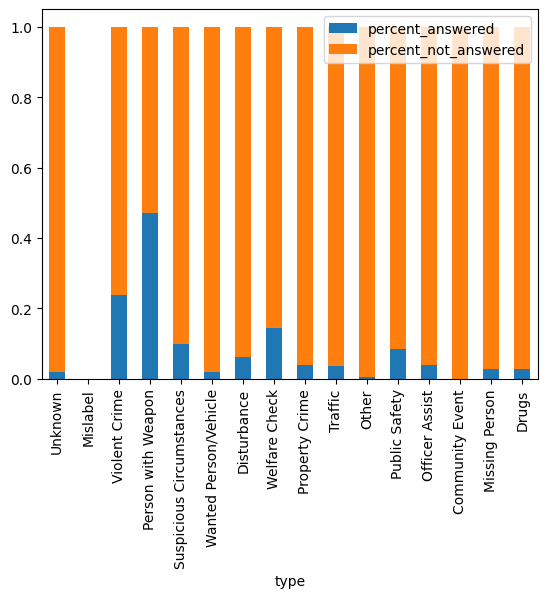

In [74]:
df.plot.bar(x='type',y=['percent_answered','percent_not_answered'],stacked=True,label=['percent_answered','percent_not_answered'])
df

In [75]:
logger.info(f"Specifically, drones were dispatched to nearly {df[df['type']=='Person with Weapon']['percent_answered'].values[0]} of the incidents involving reports of armed individuals and about {df[df['type']=='Violent Crime']['percent_answered'].values[0]} of violent crime calls.")

2024-05-22 10:03:41.156 | INFO     | __main__:<module>:1 - Specifically, drones were dispatched to nearly 0.4708097928436911 of the incidents involving reports of armed individuals and about 0.2369907820398454 of violent crime calls.


## Minor Offenses

According to WIRED’s analysis, Chula Vista Police have sent its drones to investigate hundreds of 911 calls about loud music, public intoxication, vandalism, shoplifting and other minor offenses


In [86]:
pi_music_vandal_shop_lifting = cv_flights[
    (cv_flights['clean-type'].astype(str).str.contains('intox',case=False))|
    (cv_flights['clean-type'].astype(str).str.contains('drunk in public',case=False)) |
    (cv_flights['clean-type'].astype(str).str.contains('loud',case=False)) |
    (cv_flights['clean-type'].astype(str).str.contains('party',case=False)) |
    (cv_flights['clean-type'].astype(str).str.contains('shoplifting',case=False)) |
    (cv_flights['clean-type'].astype(str).str.contains('petty',case=False)) |
    (cv_flights['clean-type'].astype(str).str.contains('noise',case=False)) |
    (cv_flights['clean-type'].astype(str).str.contains('vandalism',case=False)) |
    (cv_flights['clean-type'].astype(str).str.contains('graffiti',case=False)) |
    (cv_flights['clean-type'].astype(str).str.contains('disorderly',case=False)) 

].copy()

logger.info(f"According to WIRED’s analysis, Chula Vista Police have sent its drones to investigate {pi_music_vandal_shop_lifting.shape[0]} calls about loud music, public intoxication, vandalism, shoplifting and disorderly conduct.")

2024-05-22 10:09:16.588 | INFO     | __main__:<module>:15 - According to WIRED’s analysis, Chula Vista Police have sent its drones to investigate 201 calls about loud music, public intoxication, vandalism, shoplifting and disorderly conduct.


# Transparency

At the time of our analysis, approximately one in 10 drone flights listed on the department’s transparency portal lacked a stated purpose and could not be connected to any relevant 911 call. For residents we spoke to, the discrepancy raises serious concerns about the accuracy and reliability of the department's transparency efforts.


In [106]:
nan_flights = no_matching_cfs[no_matching_cfs['incident_id'].astype(str).str.contains('nan',case=False)]

logger.info(f"Between ({(flights_with_cfs.shape[0])/cv_flights.shape[0]}) and ({(cv_flights.shape[0]-nan_flights.shape[0])/cv_flights.shape[0]}) percent of drone flights could be connected to a CFS.")

logger.info(f"At the time of our analysis, approximately {nan_flights.shape[0]} ({nan_flights.shape[0]/cv_flights.shape[0]}) drone flights listed on the department’s transparency portal lacked a stated purpose and could not be connected to any relevant 911 call. For residents we spoke to, the discrepancy raises serious concerns about the accuracy and reliability of the department's transparency efforts.")


2024-05-22 10:55:34.604 | INFO     | __main__:<module>:3 - Between (0.8042682288942358) and (0.9060571189454963) percent of drone flights could be connected to a CFS.
2024-05-22 10:55:34.605 | INFO     | __main__:<module>:5 - At the time of our analysis, approximately 898 (0.09394288105450362) drone flights listed on the department’s transparency portal lacked a stated purpose and could not be connected to any relevant 911 call. For residents we spoke to, the discrepancy raises serious concerns about the accuracy and reliability of the department's transparency efforts.


### Orphan Flights

These unexplained flights weren’t assigned an incident number from the department—meaning they couldn’t be connected to a 911 call—and hundreds of them didn't come within half a mile of where the call originated

In [122]:
flight_blocks = pd.concat(
    [
        chunk
        for chunk in tqdm(
            pd.read_csv(
                f"../../data/outputs/outputs_drone-seconds-block-count-per-flight.csv", chunksize=100000, dtype=str
            ),
            desc="Loading data",
        )
    ]
)

orphan_flight_blocks = flight_blocks[flight_blocks['id'].isin(nan_flights['id'])]
orphan_flight_blocks['seconds'] = orphan_flight_blocks['seconds'].astype(int)

possible_cfs = []
for _, row in tqdm(nan_flights.sample(frac=1).iterrows()):
    ceiling = row['drone-date'] + datetime.timedelta(minutes = 1)
    floor = row['drone-date'] - datetime.timedelta(minutes = 90)

    blocks = orphan_flight_blocks[orphan_flight_blocks['id']==row['id']]
    lingering_blocks = ','.join(blocks.sort_values('seconds').tail(7)['GEOID20'].values)
    
    mask = (cfs['cfs-date'] > floor) & (cfs['cfs-date'] < ceiling)
    possible_calls = cfs.loc[mask].copy()
    possible_calls['possible-drone-id'] = row['id']
    possible_calls['drone-incident-id'] = row['incident_id']
    possible_calls['drone-date'] = row['drone-date']
    possible_calls['drone-type'] = row['type']
    possible_calls['drone-type'] = row['type']
    possible_calls['drone-address'] = row['address_map']
    possible_calls['drone-FIPS'] = lingering_blocks

    # possible_calls = possible_calls[possible_calls['Full FIPS (block)']==row['Full FIPS (block)']].copy()
    
    possible_cfs.append(possible_calls)
possible_cfs = pd.concat(possible_cfs)  

Loading data: 0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [123]:
possible_cfs_by_distance = []
for _, flight in tqdm(nan_flights.iterrows()):
#   find possible calls by time
    possible_cfs_for_flight = possible_cfs[possible_cfs['possible-drone-id']==flight['id']]
    
    orphan_flight = orphan_flight_blocks[orphan_flight_blocks['id']==flight['id']].copy()
    orphan_flight['seconds'] = orphan_flight['seconds'].astype(int)

    lingering_blocks = orphan_flight
    
    if lingering_blocks.shape[0]>0:
        for _, pcfs in possible_cfs_for_flight.iterrows():
            for _, block in lingering_blocks.iterrows():
                if str(block['INTPTLAT20']) != "nan":
                    try:
                        distance = geopy.distance.geodesic((pcfs['Latitude'],pcfs['Longitude']),(block['INTPTLAT20'],block['INTPTLON20'])).miles
                        if distance <= .5:
                            pcfs["lingering-block"] = block['GEOID20']
                            pcfs["distance"] = distance
                            possible_cfs_by_distance.append(pcfs)
                    except:
                        logger.error(f"{(pcfs['Latitude'],pcfs['Longitude']),(block['INTPTLAT20'],block['INTPTLON20'])}")

possible_cfs_by_distance = pd.DataFrame(possible_cfs_by_distance)         

0it [00:00, ?it/s]

In [125]:
orphans = nan_flight[~nan_flights['id'].isin(possible_cfs_by_distance['possible-drone-id'])].copy()

logger.info(f"These unexplained flights weren’t assigned an incident number from the department—meaning they couldn’t be connected to a 911 call—and {orphans.shape[0]} of them didn't come within half a mile of where the call originated.")

2024-05-22 11:13:36.212 | INFO     | __main__:<module>:3 - These unexplained flights weren’t assigned an incident number from the department—meaning they couldn’t be connected to a 911 call—and 396 of them didn't come within half a mile of where the call originated.
